In this notebook, we will implement Monte Carlo simulations to price European and exotic(Asian, Barrier), compare with Black-Scholes closed-form results, and estimate Greeks using simulations. 

-------------------

First we will start off with European Options. 


Recall: Exercised *only at expiry*. You decide whether to exercise at maturity based on the final price $S_T$.

**Black-Scholes Fomula**: use it to price Options
It is based on two ideas
1. stock prices moves randomly
2. No arbitrage principle
    - there is no way to make a guarenteed profit without taking risk or investing money
    - two portfolios that give the same future payoff must have the same price today
-> replicate the ption payoff with a combination of stock and bonds

The steps to derive the formula
1. model stock with gbm (geometric brownian motion)
2. replicate the option with a portfolio
3. Solve the PDE

**The stock price is modelled by a stochastic process**

The stock follows **Geometric Brownian Motion (GBM):**

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$

This is the **stochastic differential equation (SDE)** for the stock price.

It means:
- the stock drifts upward on average at rate $\mu$,
- and fluctuates randomly with volatility $\sigma$.

So $S_t$ is **random**.

**Black-Scholes PDE for option price**
$$
\frac{\partial V}{\partial t}
+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}
+ rS \frac{\partial V}{\partial S}
- rV = 0
$$

where $V(S, t)$ is the option price, and the **boundary condition** (final value at expiry) is:

$$
V(S, T) = \max(S - K, 0)
$$

for a **European call option**.

**After solving PDE**
For a **European call option**, the price is:

$$
C = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)
$$

and for a **European put option**:

$$
P = K e^{-rT} \Phi(-d_2) - S_0 \Phi(-d_1)
$$

where:

$$
d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}}, 
\quad 
d_2 = d_1 - \sigma \sqrt{T}
$$


---

 Explanation of Each Term

| **Symbol** | **Meaning** | **Interpretation** |
|:------------|:------------|:-------------------|
| $S_0$ | Current price of the underlying asset | Today’s stock or asset price |
| $K$ | Strike price | The price you can buy/sell the asset for at expiry |
| $T$ | Time to maturity (in years) | How long until the option expires |
| $r$ | Risk-free interest rate | Theoretical return on a zero-risk investment (e.g., Treasury bill) |
| $\sigma$ | Volatility (standard deviation of returns) | How uncertain or variable the asset’s price is |
| $e^{-rT}$ | Discount factor | Converts future payoffs to present value |
| $\Phi(x)$ | Cumulative distribution function (CDF) of a standard normal variable | Gives probability a standard normal variable ≤ $x$ |
| $d_1, d_2$ | Intermediate variables capturing how far the option is “in-the-money” in standard deviation units | Used to calculate risk-adjusted probabilities |

---
Intuitive Meaning

- $\Phi(d_1)$ → “probability-weighted exposure” to the stock (how likely it is the option finishes in the money).  
- $\Phi(d_2)$ → risk-neutral probability that the option will be exercised.  
- $S_0 \Phi(d_1)$ → expected value of receiving the stock.  
- $K e^{-rT} \Phi(d_2)$ → expected value of paying the strike at maturity (discounted).  

Hence:

> **Option value = Expected benefit of owning the stock – Expected cost of exercising the option (under risk-neutral world).**

-----------------

**What Is Monte Carlo Simulation?** 

Monte Carlo simulation is a way to **estimate a value** by using **random sampling**.

Instead of solving a formula directly, we **simulate many random scenarios** and then take the **average result**.

---

**Intuition**

Think of it like this:

We want to find the *expected value* (average outcome) of something that depends on randomness —  
for example, the future price of a stock.

Since we can’t predict exactly what will happen, we **generate many possible futures** (simulations).  
Each simulation gives us one possible outcome.

Then, by averaging all these outcomes, we get a good estimate of the *true average value*.

> The more times we simulate, the closer our estimate gets to the real value. (By law of large numbers)

---

**In Option Pricing**

In option pricing, we can’t know the future stock price —  
but we know how it *behaves on average* (using probability and volatility).

So we:
1. **Simulate many future prices** of the stock using random draws.  
2. **Compute the payoff** of the option in each simulation (e.g. $\max(S_T - K, 0)$).  
3. **Average all the payoffs** and **discount** them back to today’s value.

That average gives us the **Monte Carlo estimate** of the option price.

---

**Simple Summary**

| Step | What we do | Why |
|------|-------------|-----|
| 1 | Generate many random outcomes | Represent all possible futures |
| 2 | Compute the result for each outcome | Get what the payoff would be |
| 3 | Take the average | Estimate the expected value |
| 4 | Discount back to present | Get today’s fair price |

---

> **In short:**  
> Monte Carlo simulation means *“simulate it many times and take the average”*.  
> It turns randomness into a reliable estimate through repetition.
----------------------------------------

**Implementation: Pricing European Options using Monte Carlo Simulations**

In [2]:
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

Black-Scholes closed form

For a **European call option**, the price is:

$$
C = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)
$$

and for a **European put option**:

$$
P = K e^{-rT} \Phi(-d_2) - S_0 \Phi(-d_1)
$$

where:

$$
d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}}, 
\quad 
d_2 = d_1 - \sigma \sqrt{T}
$$

**note there is an edge case where sigma = 0, so we just treat future stock price as an exponential growth at risk free rate

Call Option (Buy Call)

$
\text{Payoff} = \max(S_T - K, 0)
$

- If $S_T > K$, you exercise (profit).  
- If $S_T \le K$, the option expires worthless.  

Put Option (Buy Put)

$
\text{Payoff} = \max(K - S_T, 0)
$

In [3]:
def bs_price(S0, K, T, r, sigma, call: bool = True):
    if sigma == 0:
        ST = S0 * math.exp(r * T)
        payoff = max(ST - K, 0) if call else max(K - ST, 0)
        return payoff * math.exp(-r * T)  # Discounted payoff for present value
    
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if call:
        return S0 * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    else:
        return K * math.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

Based on the stock prices GBM model, we get the exact analytical solution:
$$
S_T = S_0 \, e^{(r - \tfrac{1}{2}\sigma^2)T + \sigma W_T}
$$

Since $W_T \sim \mathcal{N}(0, T)$, we can write:

$$
W_T = \sqrt{T} Z, \quad \text{where } Z \sim \mathcal{N}(0,1)
$$

So:

$$
\boxed{S_T = S_0 \, e^{(r - \tfrac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z}}
$$


We then use monte carlo to simulate $S_T$ using GBM

In [4]:
def sim_ST(S0, T, r, sigma, Z):
    Z = np.array(Z, dtype=np.float64)
    drift = (r - 0.5 * sigma ** 2) * T
    diffusion = sigma * math.sqrt(T) * Z
    return S0 * np.exp(drift + diffusion)

Monte Carlo Pricing + two variance reduction methods (antithetic, control variate)

**Plain Monte Carlo (baseline)**

- **Idea:** simulate many independent scenarios of $S_T$, compute the discounted payoff, and take the average.

- **Estimator:**
  $$
  \hat{Y}_{\text{plain}} = \frac{1}{N} \sum_{i=1}^{N} e^{-rT} \, \text{payoff}(S_T^{(i)})
  $$

- **Convergence:** unbiased; standard error $\approx \sigma_Y / \sqrt{N}$ (from CLT).

---

**Antithetic variates (variance reduction)**

- **Idea:** for each random draw $Z \sim \mathcal{N}(0,1)$, also use its mirror $-Z$.
- For GBM, $S_T(Z)$ and $S_T(-Z)$ are **negatively correlated** for monotone payoffs (calls/puts),  
  so the **average of the pair** has lower variance.

- **Estimator (per pair):**
  $$
  \hat{Y} = \tfrac{1}{2} \big( Y(Z) + Y(-Z) \big)
  $$
  then average across pairs.

--- 
 **Control variate (variance reduction)**

- **Idea:** subtract noise from a correlated variable with known mean.
- Choose $C = e^{-rT} S_T$.  
  Under the risk-neutral measure, $\mathbb{E}[C] = S_0$ (exactly).
- $Y = e^{-rT} max(S_T - K, 0)$ for call, $Y = e^{-rT} max(K - S_T, 0)$ for put

- **Adjusted estimator:**
  $$
  Y_{\text{cv}} = Y - b^{*}(C - \mathbb{E}[C]), 
  \quad \text{where} \quad b^{*} = \frac{\text{Cov}(Y, C)}{\text{Var}(C)}
  $$

- This keeps the estimator **unbiased**, but can cut variance a lot when $Y$ and $C$ are highly correlated (they are, for Europeans).

In [5]:
def make_rng(seed: int | None = 42) -> np.random.Generator:
    return np.random.default_rng(seed)

In [6]:
def mc_euro(
    S0, K, T, r, sigma, 
    n_paths, 
    call=True,
    antithetic=False,
    control_variate=False,
    seed=123
):
    rng = make_rng(seed)

    if antithetic:
        # generate half, then mirror
        m = (n_paths + 1) // 2
        Z = rng.standard_normal(m)
        Z = np.concatenate([Z, -Z])[:n_paths]
    else:
        Z = rng.standard_normal(n_paths)

    ST = sim_ST(S0, T, r, sigma, Z)
    if call:
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)

    disc = math.exp(-r * T)
    Y = disc * payoff  # base estimator

    if control_variate:
        # Control variate: C = e^{-rT} S_T, with E[C] = S0
        C = disc * ST
        C_mean = S0
        # Optimal coefficient b* = Cov(Y, C)/Var(C)
        cov = np.cov(Y, C, ddof=1)[0, 1]
        varC = np.var(C, ddof=1)
        b_star = cov / varC if varC > 0 else 0.0
        Y = Y - b_star * (C - C_mean)

    price = float(np.mean(Y))
    se    = float(np.std(Y, ddof=1) / math.sqrt(n_paths))
    ci95  = (price - 1.96 * se, price + 1.96 * se)
    return price, se, ci95, n_paths

In [8]:
# Parameters
S0, K, T, r, sigma = 100.0, 100.0, 1.0, 0.05, 0.20

bs_call = bs_price(S0, K, T, r, sigma, call=True)
bs_put  = bs_price(S0, K, T, r, sigma, call=False)

print(f"Black–Scholes call: {bs_call:.6f}")
print(f"Black–Scholes put : {bs_put:.6f}")

# Baseline Monte Carlo (plain)
res_plain = mc_euro(S0, K, T, r, sigma, n_paths=100_000, call=True, antithetic=False, control_variate=False, seed=1)
print("MC plain (call)", res_plain)

Black–Scholes call: 10.450584
Black–Scholes put : 5.573526
MC plain (call) (10.357757644151459, 0.046422222989210477, (10.266770087092606, 10.448745201210311), 100000)


In [10]:
N = 100_000

res_anti  = mc_euro(S0, K, T, r, sigma, n_paths=N, call=True, antithetic=True,  control_variate=False, seed=2)
res_cv    = mc_euro(S0, K, T, r, sigma, n_paths=N, call=True, antithetic=False, control_variate=True,  seed=3)
res_both  = mc_euro(S0, K, T, r, sigma, n_paths=N, call=True, antithetic=True,  control_variate=True,  seed=4)

print("MC plain",          res_plain)
print("MC + antithetic",   res_anti)
print("MC + control var",  res_cv)
print("MC + both",         res_both)

MC plain (10.357757644151459, 0.046422222989210477, (10.266770087092606, 10.448745201210311), 100000)
MC + antithetic (10.420067881958555, 0.046481167826904334, (10.328964793017823, 10.511170970899288), 100000)
MC + control var (10.447535213689495, 0.017700337249657017, (10.412842552680168, 10.482227874698822), 100000)
MC + both (10.459041305560662, 0.0176746547167031, (10.424398982315925, 10.4936836288054), 100000)


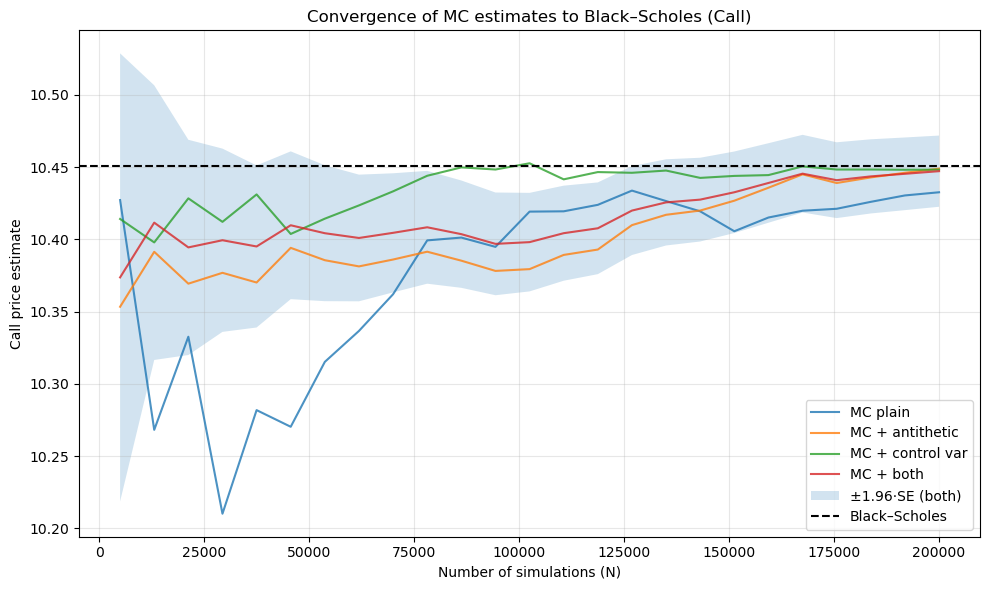

In [15]:
Ns = np.linspace(5_000, 200_000, 25, dtype=int)

# Store results for different variance reduction methods
estimates_plain = []
estimates_anti = []
estimates_cv = []
estimates_both = []
ses_plain = []
ses_anti = []
ses_cv = []
ses_both = []

for n in Ns:
    # Plain MC
    res_plain = mc_euro(S0, K, T, r, sigma, n_paths=n, call=True,
                       antithetic=False, control_variate=False, seed=999)
    estimates_plain.append(res_plain[0])
    ses_plain.append(res_plain[1])
    
    # MC + Antithetic
    res_anti = mc_euro(S0, K, T, r, sigma, n_paths=n, call=True,
                      antithetic=True, control_variate=False, seed=999)
    estimates_anti.append(res_anti[0])
    ses_anti.append(res_anti[1])
    
    # MC + Control Variate
    res_cv = mc_euro(S0, K, T, r, sigma, n_paths=n, call=True,
                    antithetic=False, control_variate=True, seed=999)
    estimates_cv.append(res_cv[0])
    ses_cv.append(res_cv[1])
    
    # MC + Both
    res_both = mc_euro(S0, K, T, r, sigma, n_paths=n, call=True,
                      antithetic=True, control_variate=True, seed=999)
    estimates_both.append(res_both[0])
    ses_both.append(res_both[1])

# Convert to arrays
estimates_plain = np.array(estimates_plain)
estimates_anti = np.array(estimates_anti)
estimates_cv = np.array(estimates_cv)
estimates_both = np.array(estimates_both)
ses_plain = np.array(ses_plain)
ses_anti = np.array(ses_anti)
ses_cv = np.array(ses_cv)
ses_both = np.array(ses_both)

plt.figure(figsize=(10,6))
plt.plot(Ns, estimates_plain, label="MC plain", alpha=0.8)
plt.plot(Ns, estimates_anti, label="MC + antithetic", alpha=0.8)
plt.plot(Ns, estimates_cv, label="MC + control var", alpha=0.8)
plt.plot(Ns, estimates_both, label="MC + both", alpha=0.8)
plt.fill_between(Ns, estimates_both - 1.96*ses_both, estimates_both + 1.96*ses_both, alpha=0.2, label="±1.96·SE (both)")
plt.axhline(bs_call, linestyle="--", color="black", label="Black–Scholes")
plt.xlabel("Number of simulations (N)")
plt.ylabel("Call price estimate")
plt.title("Convergence of MC estimates to Black–Scholes (Call)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()